# End-to-End Quantitative Strategy Workflow

This notebook demonstrates a complete end-to-end workflow for a quantitative trading strategy, including:

1.  **Factor Calculation**: Running a deep learning model to generate predictive factor scores.
2.  **Portfolio Optimization**: Converting raw factor scores into optimized portfolio weights using a layered optimizer.
3.  **Backtesting**: Simulating the strategy's historical performance using the generated weights and a high-performance Rust-based backtester.

## Step 0: Setup and Imports

First, we import all necessary libraries and custom modules. We also add the project's root directory to the system path to ensure that our custom modules (`longgang_trader`) can be found.

In [1]:
import os
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import polars as pl
import yaml
import torch
import json
import shutil

project_root = Path.cwd()
while not(project_root /'pyproject.toml').exists() and project_root != project_root.parent:
    project_root = project_root.parent

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
    print(f"Added {project_root} to sys.path")

Added d:\Notes\Project\LongGangTrader to sys.path


In [2]:

# Import custom modules using absolute imports (project_root is added to sys.path in an earlier cell).
from longgang_trader.alpha.dl_model_factor import inference_on_test_set, load_config
from longgang_trader.backtesting.backtester import Backtester
from longgang_trader.backtesting.strategy import RollingTopQuantileStrategy

print("Setup complete. All modules imported.")

Setup complete. All modules imported.


In [7]:
weights_df = pl.read_csv("../data/all_weight_atr.csv")


In [8]:

weights_df = weights_df.unpivot(
    index=[""],
    variable_name="code",
    value_name="weight"
).with_columns(
    pl.col('').cast(pl.Utf8).str.strptime(pl.Date, format="%Y%m%d").alias("date")
).drop([""])

In [12]:
weights_df = weights_df.with_columns(
    pl.when(pl.col("date")<pl.date(2023,1,1)).then(
        pl.lit(0.0)
    ).otherwise(pl.col("weight")).alias("weight")
)

In [24]:
config_strategy = {
    "rolling_window": 10,
    "quantile": 0.9,
    "min_score": 0.0,
    "date_col":"date",
    "symbol_col":"code",
    "weight_col":"weight",
}
strategy = RollingTopQuantileStrategy(factor_data=(weights_df).to_pandas(), config=config_strategy)

In [25]:
config_backtester = {
    "date_col":"date",
    "symbol_col":"code",
    "weight_col":"weight",
}
backtester = Backtester(strategy=strategy, data_path="../data/baostock_data_formatted.parquet",config=config_backtester)


生成的交易信号 (Rolling Top 9% Strategy):
总交易日数: 487
平均每日持仓数: 234.49
信号数据预览:
shape: (5, 3)
┌─────────────────────┬───────────┬──────────┐
│ date                ┆ code      ┆ weight   │
│ ---                 ┆ ---       ┆ ---      │
│ datetime[ms]        ┆ str       ┆ f64      │
╞═════════════════════╪═══════════╪══════════╡
│ 2023-11-14 00:00:00 ┆ 000001.SZ ┆ 0.000221 │
│ 2023-11-15 00:00:00 ┆ 000001.SZ ┆ 0.000456 │
│ 2023-11-16 00:00:00 ┆ 000001.SZ ┆ 0.0007   │
│ 2023-11-17 00:00:00 ┆ 000001.SZ ┆ 0.000961 │
│ 2023-11-20 00:00:00 ┆ 000001.SZ ┆ 0.001244 │
└─────────────────────┴───────────┴──────────┘
Rust 回测成功完成。


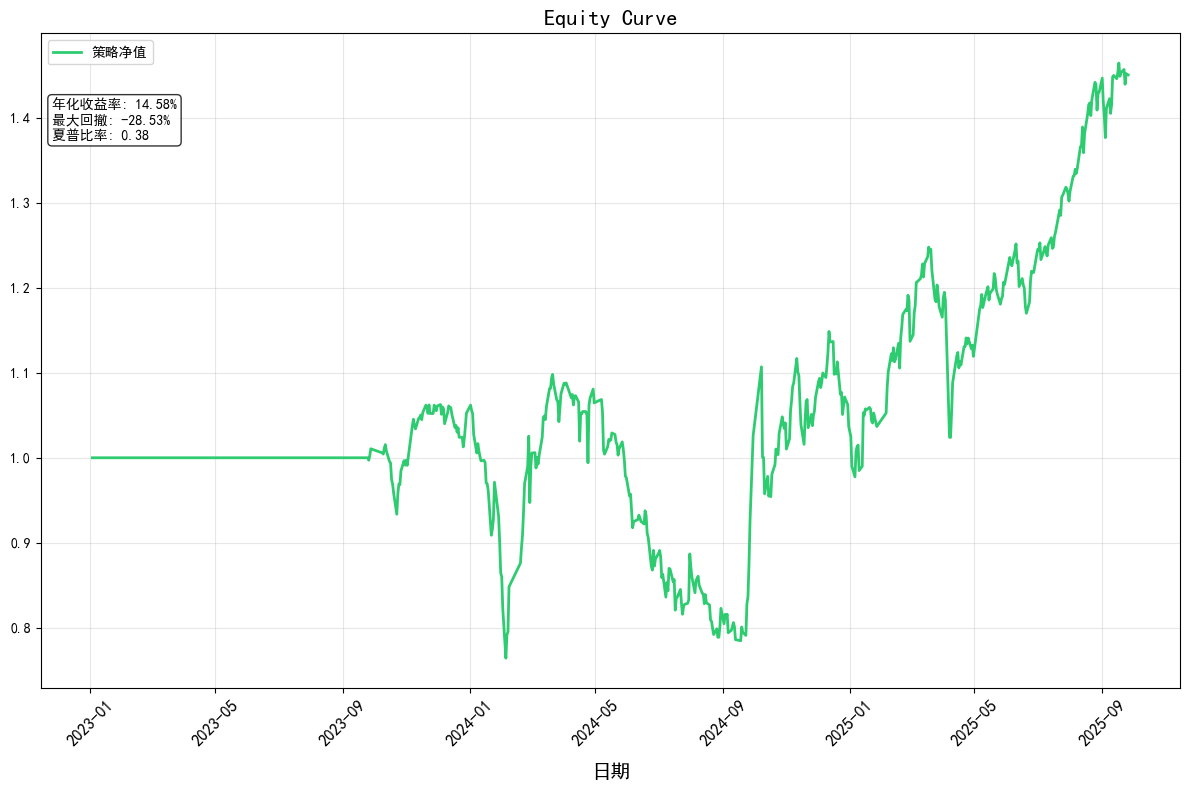

In [26]:
backtester.run_backtest()
backtester.plot_equity_curve()

In [6]:
signals = strategy.generate_signals_for_all_dates()

: 